In [ ]:
#pip install protobuf==4.24.4
#TensorFlow version: 2.14.0
#Protocol Buffers version: 4.24.4

  Using cached protobuf-4.24.4-cp310-abi3-win_amd64.whl.metadata (540 bytes)
Using cached protobuf-4.24.4-cp310-abi3-win_amd64.whl (430 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-nightly-intel 2.17.0.dev20240322 requires ml-dtypes~=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.


In [ ]:
# Import necessary libraries for Data Collection
import time
import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
import google.protobuf

print("TensorFlow version:", tf.__version__)
print("Protocol Buffers version:", google.protobuf.__version__)


TensorFlow version: 2.16.1
Protocol Buffers version: 4.24.4


In [ ]:
# Define stock tickers and date range
stock_tickers = ['AAPL', 'GOOGL']
start_date = '2000-07-01'
end_date = '2023-10-04'


In [ ]:
# Function to collect data for a given stock
def collect_data(ticker):
    start_date = datetime.datetime(2020, 1, 1, 23, 59)
    end_date = datetime.datetime(2024, 4, 12, 23, 59)
    interval = '1d'
    period1 = int(time.mktime(start_date.timetuple()))
    period2 = int(time.mktime(end_date.timetuple()))
    query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
    df = pd.read_csv(query_string)

    return df

In [ ]:
# Collect data for multiple stocks in parallel
def collect_data_parallel(stock_tickers):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        dataframes = list(executor.map(collect_data, stock_tickers))
    return dataframes

In [ ]:
# Collect data for multiple stocks
dataframes = collect_data_parallel(stock_tickers)
dataframes[1]

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,67.420502,68.433998,67.324501,68.433998,68.433998,27278000
1,2020-01-03,67.400002,68.687500,67.365997,68.075996,68.075996,23408000
2,2020-01-06,67.581497,69.916000,67.550003,69.890503,69.890503,46768000
3,2020-01-07,70.023003,70.175003,69.578003,69.755501,69.755501,34330000
4,2020-01-08,69.740997,70.592499,69.631500,70.251999,70.251999,35314000
...,...,...,...,...,...,...,...
1072,2024-04-08,152.779999,155.270004,152.610001,154.850006,154.850006,20702000
1073,2024-04-09,156.089996,158.559998,155.190002,156.600006,156.600006,31113000
1074,2024-04-10,156.210007,156.610001,154.679993,156.139999,156.139999,22838600
1075,2024-04-11,156.910004,159.679993,156.460007,159.410004,159.410004,27166400


In [ ]:
# Function to clean data for a given stock
def clean_data(df):
    missing_data = df.isnull().sum()
    print("Missing data:\n", missing_data)
    # For simplicity, using linear interpolation to handle missing values
    df = df.interpolate(method='linear', inplace=False)
    return df

In [ ]:
# Parallel data cleaning for multiple stocks
with concurrent.futures.ThreadPoolExecutor() as executor:
    cleaned_data = list(executor.map(clean_data, dataframes))


Missing data:
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Missing data:
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
# Feature Engineering
columns_to_process = ['Close','High']
def feature_engineering(df):
    return df[columns_to_process]  # Only 'Close' and 'High' columns

In [ ]:
# Apply feature engineering for each stock's data
with concurrent.futures.ThreadPoolExecutor() as executor:
    feature_data = list(executor.map(feature_engineering, cleaned_data))
feature_data[1]

,Close,High
0,68.433998,68.433998
1,68.075996,68.687500
2,69.890503,69.916000
3,69.755501,70.175003
4,70.251999,70.592499
...,...,...
1072,154.850006,155.270004
1073,156.600006,158.559998
1074,156.139999,156.610001
1075,159.410004,159.679993


In [ ]:
dataframes = feature_data
type(dataframes[0])

pandas.core.frame.DataFrame

In [ ]:
dataframe_dict = {}
for i in range(len(stock_tickers)):
    dataframe_dict[stock_tickers[i]] = dataframes[i]


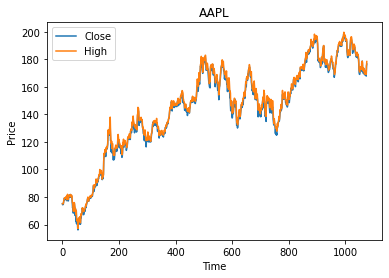

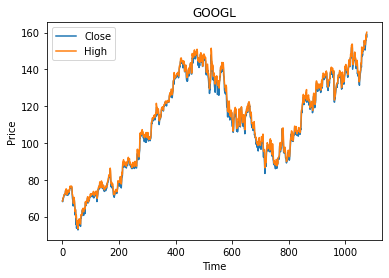

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Extract stock names and DataFrames from the dictionary
stock_names = list(dataframe_dict.keys())
dataframes = list(dataframe_dict.values())

# Create a color palette for the columns
num_columns = len(columns_to_process)
colors = plt.cm.tab10(range(num_columns))

# Iterate over stock names and DataFrames
for i, (stock_name, data_frame) in enumerate(zip(stock_names, dataframes)):
    # Create a subplot for each stock
    fig, ax = plt.subplots()

    # Plot original data for each column with a unique color
    for j, col_name in enumerate(columns_to_process):
        original_data = data_frame[col_name]
        ax.plot(original_data, label=col_name, color=colors[j])

    # Set labels and title
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.set_title(stock_name)

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()

In [ ]:
feature_data

[           Close        High
 0      75.087502   75.150002
 1      74.357498   75.144997
 2      74.949997   74.989998
 3      74.597504   75.224998
 4      75.797501   76.110001
 ...          ...         ...
 1072  168.449997  169.199997
 1073  169.669998  170.080002
 1074  167.779999  169.089996
 1075  175.039993  175.460007
 1076  176.550003  178.360001
 
 [1077 rows x 2 columns],
            Close        High
 0      68.433998   68.433998
 1      68.075996   68.687500
 2      69.890503   69.916000
 3      69.755501   70.175003
 4      70.251999   70.592499
 ...          ...         ...
 1072  154.850006  155.270004
 1073  156.600006  158.559998
 1074  156.139999  156.610001
 1075  159.410004  159.679993
 1076  157.729996  160.220001
 
 [1077 rows x 2 columns]]

In [ ]:
# Parallel data processing function
stocks_scalers = {}
stocks_dict = {}

def all_stocks(stock_name):
    df = dataframe_dict[stock_name]

    def process_column(column_name):
        df_column = df[[column_name]]

        # Data scaling
        scaler = MinMaxScaler(feature_range=(0, 1))
        print(df_column)
        df_column_scaled = scaler.fit_transform(np.array(df_column).reshape(-1, 1))
        print(scaler.inverse_transform(df_column_scaled))
        return column_name, df_column_scaled, scaler

    # Number of parallel jobs
    num_jobs = len(columns_to_process)

    # Perform data processing in parallel
    processed_data = Parallel(n_jobs=num_jobs)(
        delayed(process_column)(column_name) for column_name in columns_to_process
    )

    # Store the processed data in a dictionary
    processed_data_dict = {col_name: data for col_name, data, _ in processed_data}
    stocks_dict[stock_name] = processed_data_dict

    # Store the scalers in the stocks_scalers dictionary
    scalers = {col_name: scalerss for col_name, _, scalerss in processed_data}
    stocks_scalers[stock_name] = scalers

for i in stock_tickers:
    all_stocks(i)

# Access the stocks_dict and stocks_scalers dictionaries as needed
#print(stocks_scalers)


In [ ]:
stocks_scalers['AAPL']['Close'].inverse_transform(stocks_dict['AAPL']['Close'])

array([[ 75.087502],
       [ 74.357498],
       [ 74.949997],
       ...,
       [167.779999],
       [175.039993],
       [176.550003]])

In [ ]:
stocks_dict

{'AAPL': {'Close': array([[0.13375114],
         [0.1286109 ],
         [0.13278292],
         ...,
         [0.78643476],
         [0.83755518],
         [0.84818774]]),
  'High': array([[0.12649568],
         [0.12646056],
         [0.12537281],
         ...,
         [0.78574687],
         [0.83045027],
         [0.85080182]])},
 'GOOGL': {'Close': array([[0.14739438],
         [0.14403927],
         [0.1610444 ],
         ...,
         [0.96935429],
         [1.        ],
         [0.98425536]]),
  'High': array([[0.14117958],
         [0.14355154],
         [0.15504633],
         ...,
         [0.96622206],
         [0.99494727],
         [1.        ]])}}

In [ ]:
"""
# Parallel data processing function
stocks_scalers = {}
stocks_dict = {}
def all_stocks(stock_name):
    df = dataframe_dict[stock_name]
    def process_column(column_name):
        df_column = df[[column_name]]

        # Data scaling
        scaler = MinMaxScaler(feature_range=(0,1))
        #df_column_scaled = scaler.fit_transform(np.array(df_column).reshape(-1,1))
        return scaler
    scalers_dict = {}
    for i in columns_to_process:
        scalers_dict[i] = process_column(i)
    def process_column(column_name):
        df_column = df[[column_name]]

        # Data scaling
        scaler = MinMaxScaler(feature_range=(0,1))
        df_column_scaled = scaler.fit_transform(np.array(df_column).reshape(-1,1))
        scalers_dict[column_name] = scaler
        print(scalers_dict)
        return column_name, df_column_scaled

    # Number of parallel jobs
    num_jobs = len(columns_to_process)

    # Perform data processing in parallel
    processed_data = Parallel(n_jobs=num_jobs)(
        delayed(process_column)(column_name) for column_name in columns_to_process
    )
    # Store the processed data in a dictionary
    processed_data_dict = {col_name: data for col_name, data in processed_data}
    stocks_dict[stock_name] = processed_data_dict
    return scalers_dict
    """

'\n# Parallel data processing function\nstocks_scalers = {}\nstocks_dict = {}\ndef all_stocks(stock_name):\n    df = dataframe_dict[stock_name]\n    def process_column(column_name):\n        df_column = df[[column_name]]\n   \n        # Data scaling\n        scaler = MinMaxScaler(feature_range=(0,1))\n        #df_column_scaled = scaler.fit_transform(np.array(df_column).reshape(-1,1))\n        return scaler\n    scalers_dict = {}\n    for i in columns_to_process:\n        scalers_dict[i] = process_column(i)\n    def process_column(column_name):\n        df_column = df[[column_name]]\n   \n        # Data scaling\n        scaler = MinMaxScaler(feature_range=(0,1))\n        df_column_scaled = scaler.fit_transform(np.array(df_column).reshape(-1,1))\n        scalers_dict[column_name] = scaler\n        print(scalers_dict)\n        return column_name, df_column_scaled\n   \n    # Number of parallel jobs\n    num_jobs = len(columns_to_process)\n\n    # Perform data processing in parallel\n    p

In [ ]:
stocks_dict

{'AAPL': {'Close': array([[0.13375114],
         [0.1286109 ],
         [0.13278292],
         ...,
         [0.78643476],
         [0.83755518],
         [0.84818774]]),
  'High': array([[0.12649568],
         [0.12646056],
         [0.12537281],
         ...,
         [0.78574687],
         [0.83045027],
         [0.85080182]])},
 'GOOGL': {'Close': array([[0.14739438],
         [0.14403927],
         [0.1610444 ],
         ...,
         [0.96935429],
         [1.        ],
         [0.98425536]]),
  'High': array([[0.14117958],
         [0.14355154],
         [0.15504633],
         ...,
         [0.96622206],
         [0.99494727],
         [1.        ]])}}

In [ ]:
type(feature_data)

list

In [ ]:
from datetime import datetime, timedelta

# Get today's date
end_date = datetime.now()

# Calculate the start date (7 days ago)
start_date = end_date - timedelta(days=7)

# Format dates as strings
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

print("Start Date:", start_date_str)
print("End Date:", end_date_str)


Start Date: 2024-04-07
End Date: 2024-04-14


In [ ]:
import numpy as np
import requests
from textblob import TextBlob  # For sentiment analysis

# Function to collect news articles for a given stock
def collect_news_articles(stock_ticker, start_date, end_date):
    news_api_key = '5639ae4631f5427a8537d0b5904e662e'  # Replace with your actual News API key
    news_url = f'https://newsapi.org/v2/everything?q={stock_ticker}&from={start_date}&to={end_date}&apiKey={news_api_key}'
    response = requests.get(news_url)
    articles = response.json()['articles']
    return [article['title'] for article in articles]

# Perform sentiment analysis on news articles
def perform_sentiment_analysis(stock_ticker, start_date, end_date):
    news_articles = collect_news_articles(stock_ticker, start_date, end_date)
    sentiment_scores = [TextBlob(article).sentiment.polarity for article in news_articles]
    average_sentiment = np.mean(sentiment_scores)
    return average_sentiment

# Get sentiment scores for each stock
sentiment_scores = {}
for stock_ticker, data in stocks_dict.items():
    sentiment_score = perform_sentiment_analysis(stock_ticker, start_date, end_date)
    sentiment_scores[stock_ticker] = sentiment_score

# Add 'Sentiment' column to each stock in the dictionary
for stock_ticker, data in stocks_dict.items():
    # Get the close prices array
    close_prices = data['Close']
    # Determine the number of rows (should match the number of sentiment scores)
    num_rows = close_prices.shape[0]
    # Create an array with the sentiment score repeated for each row
    sentiment_column = np.full((num_rows, 1), sentiment_scores[stock_ticker])
    # Concatenate the sentiment column with the existing data
    stocks_dict[stock_ticker]['Sentiment'] = sentiment_column

# Now each stock in the stocks_dict dictionary will have a 'Sentiment' column containing the sentiment scores.


In [ ]:
stocks_dict['AAPL']['Sentiment']

array([[0.02503098],
       [0.02503098],
       [0.02503098],
       ...,
       [0.02503098],
       [0.02503098],
       [0.02503098]])

In [ ]:
sentiment_scores

{'AAPL': 0.02503097643097643, 'GOOGL': 0.04765553175346989}

In [ ]:
time_step = 100
def create_dataset(dataset):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step)]
        dataX.append(a)
        dataY.append(dataset[i + time_step])
    return np.array(dataX), np.array(dataY)


In [ ]:
import concurrent.futures
train_rmse_values = []
test_rmse_values = []
t=[]
x_input_dict = {}
time_step=100
def train_model(stock_name, column_name, df_column, sentiment_score):
    future_days = 30
    training_size = int(len(df_column) * 0.65)
    test_size = len(df_column) - training_size
    train_data, test_data = df_column[0:training_size, :], df_column[training_size:len(df_column), :1]
    x_input = test_data
    if stock_name not in x_input_dict:
        x_input_dict[stock_name] = {}
    x_input_dict[stock_name][column_name] = x_input
    X_train, y_train = create_dataset(train_data)
    X_test, y_test = create_dataset(test_data)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    y_train = stocks_scalers[stock_name][column_name].fit_transform(y_train)
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1))
    )
    model.add(tf.keras.layers.LSTM(50, return_sequences=True))
    model.add(tf.keras.layers.LSTM(50))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss="mean_squared_error", optimizer="adam")
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    if stock_name == 'AAPL' and col_name == 'Close':
        t.append(stocks_scalers[stock_name][column_name])
    #train_predict = stocks_scalers[stock_name][column_name].inverse_transform(train_predict)
    #test_predict = stocks_scalers[stock_name][column_name].inverse_transform(test_predict)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
    train_rmse_values.append(train_rmse)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
    test_rmse_values.append(test_rmse)
    print(f"{stock_name}-{column_name} - Train RMSE:", train_rmse)
    print(f"{stock_name}-{column_name} - Test RMSE:", test_rmse)
    return column_name, model, stocks_scalers[stock_name][column_name], train_predict, test_predict


In [ ]:
# Parallel training of models
def train_models(stock_name):
    trained_models_data = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=len(columns_to_process)) as executor:
        trained_models_data = list(executor.map(lambda col_name: train_model(stock_name, col_name, stocks_dict[stock_name][col_name], sentiment_score), columns_to_process))

    # Create a dictionary of trained models and scalers
    trained_models_dict = {col_name: (model, scaler, train_pred, test_pred) for col_name, model, scaler, train_pred, test_pred in trained_models_data}
    return trained_models_dict

# Train models for all stocks
with concurrent.futures.ThreadPoolExecutor() as executor:
    stocks_model_data = list(executor.map(train_models, stock_tickers))


C:\Users\Purushottham\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\Purushottham\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\Purushottham\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 593ms/step - loss: 0.1926 - val_loss: 0.0046
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 632ms/step - loss: 0.2503 - val_loss: 0.0172
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 679ms/step - loss: 0.2100 - val_loss: 0.0019
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 675ms/step - loss: 0.2025 - val_loss: 0.0054
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 301ms/step - loss: 0.0195 - val_loss: 0.0117
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 296ms/step - loss: 0.0306 - val_loss: 0.0168
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 298ms/step - loss: 0.0193 - val_loss: 0.0094
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 297ms/step - loss: 0.0248 - val_loss: 0.0113
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 308ms/step - loss: 0.0140 - val_loss: 0.0075
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 307ms/step - loss: 0.0171 - val_loss: 0.0028
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 287ms/step - loss: 0.0156 - val_loss: 0.0073
Epo

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 360ms/step - loss: 0.0039 - val_loss: 0.0055
Epoch 19/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 355ms/step - loss: 0.0045 - val_loss: 0.0059
Epoch 17/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 402ms/step - loss: 0.0038 - val_loss: 0.0045
Epoch 19/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 391ms/step - loss: 0.0043 - val_loss: 0.0072
Epoch 20/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 398ms/step - loss: 0.0037 - val_loss: 0.0047
Epoch 20/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 374ms/step - loss: 0.0042 - val_loss: 0.0064
Epoch 18/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 363ms/step - loss: 0.0038 - val_loss: 0.0045
Epoch 20/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 353ms/step - loss: 0.0038 - val_loss: 0.0138
Epoch 21/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 343ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 21/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 19/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - loss: 0.0038 - val_loss: 0.0045
Epoch 21/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 30

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 0.0038Epoch 34/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 327ms/step - loss: 0.0026 - val_loss: 0.0045
Epoch 36/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 329ms/step - loss: 0.0038 - val_loss: 0.0059
Epoch 33/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - loss: 0.0028 - val_loss: 0.0086
Epoch 35/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 338ms/step - loss: 0.0031 - val_loss: 0.0059
Epoch 35/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 338ms/step - loss: 0.0028 - val_loss: 0.0042
Epoch 37/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 332ms/step - loss: 0.0032 - val_loss: 0.0061
Epoch 34/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 36/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 308ms/step - loss: 0.0031 - val_loss: 0.0045
Epoch 36/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - loss: 0.0029 - val_loss: 0.0042
Epoch 38/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 35/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - loss: 0.0

Epoch 52/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 338ms/step - loss: 0.0027 - val_loss: 0.0072
Epoch 51/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 349ms/step - loss: 0.0023 - val_loss: 0.0045
Epoch 50/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 339ms/step - loss: 0.0027 - val_loss: 0.0051
Epoch 50/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 329ms/step - loss: 0.0026 - val_loss: 0.0045
Epoch 53/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step - loss: 0.0024 - val_loss: 0.0185
Epoch 52/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 330ms/step - loss: 0.0024 - val_loss: 0.0041
Epoch 51/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 324ms/step - loss: 0.0028 - val_loss: 0.0041
Epoch 51/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - loss: 0.0023 - val_loss: 0.0045
Epoch 54/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 310ms/step - loss: 0.0026 - val_loss: 0.0057
Epoch 53/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - loss: 0.0024 - val_loss: 0.0035
Epoch 52/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step - loss: 0.0029 - val_loss: 0.0045
Epoch 52/100
10/10 ━━━━━━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - loss: 0.0018 - val_loss: 0.0041
Epoch 69/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - loss: 0.0020 - val_loss: 0.0107
Epoch 68/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 270ms/step - loss: 0.0020 - val_loss: 0.0048
Epoch 68/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - loss: 0.0025 - val_loss: 0.0100
Epoch 66/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - loss: 0.0019 - val_loss: 0.0037
Epoch 70/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - loss: 0.0018 - val_loss: 0.0057
Epoch 69/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - loss: 0.0021 - val_loss: 0.0037
Epoch 69/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - loss: 0.0025 - val_loss: 0.0085
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 0.0019Epoch 67/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 71/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - loss: 0.0019 - val_loss: 0.0090
Epoch 70/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 263ms/step - loss: 0.0022 - val_los

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 265ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 86/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - loss: 0.0023 - val_loss: 0.0073
Epoch 82/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 267ms/step - loss: 0.0018 - val_loss: 0.0040
Epoch 84/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - loss: 0.0015 - val_loss: 0.0086
Epoch 84/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - loss: 0.0017 - val_loss: 0.0046
Epoch 87/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - loss: 0.0021 - val_loss: 0.0094
Epoch 83/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - loss: 0.0015 - val_loss: 0.0182
Epoch 85/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 88/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - loss: 0.0021 - val_loss: 0.0065
Epoch 84/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 85/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - loss: 0.0016 - val_loss: 0.0128
Epoch 86/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 23

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 99/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - loss: 0.0019 - val_loss: 0.0123
Epoch 99/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - loss: 0.0
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/steptep - loss: 0.001
GOOGL-High - Train RMSE: 0.045740730946685716
GOOGL-High - Test RMSE: 0.07155569185249996
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - loss: 0.0016 - val_loss: 0.0068
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - loss: 0.0015 - val_loss: 0.0047
Epoch 100/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - loss: 0.0018 - val_loss: 0.0086
Epoch 100/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - loss: 0.0017 - val_loss: 0.0028
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.0016 - val_loss: 0.0086
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/stepst
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step  AAPL-High - Train RMSE: 0.03520155621308776
AAPL-High - Test RMSE: 0.08243671387212122
19/19 ━━━━━━━━

In [ ]:
columns_to_process

['Close', 'High']

In [ ]:
stocks_model_dict = {}

# Iterate over stock names and DataFrames
for stock_name, data_frame, trained_models_dict in zip(stock_names, dataframes, stocks_model_data):
    # Create a dictionary for the current stock's models
    stock_models = {}

    # Iterate over columns and models
    for col_name, (model, scaler, train_pred, test_pred) in trained_models_dict.items():
        # Add the column's model to the stock's model dictionary
        stock_models[col_name] = model,scaler,train_pred,test_pred

    # Add the stock name and its model dictionary to the main dictionary
    stocks_model_dict[stock_name] = stock_models


In [ ]:
stocks_scalers['AAPL']['Close'].inverse_transform(stocks_model_dict['AAPL']['Close'][3])

array([[0.6585258 ],
       [0.67025745],
       [0.6773721 ],
       [0.67743725],
       [0.6741682 ],
       [0.6719261 ],
       [0.6719377 ],
       [0.67644596],
       [0.68284506],
       [0.69138455],
       [0.70199376],
       [0.71093476],
       [0.71778506],
       [0.7234614 ],
       [0.725651  ],
       [0.7240898 ],
       [0.7234584 ],
       [0.7260959 ],
       [0.7335986 ],
       [0.7447839 ],
       [0.75582886],
       [0.76227194],
       [0.7647872 ],
       [0.76166797],
       [0.7537947 ],
       [0.7435494 ],
       [0.73970634],
       [0.74187326],
       [0.7475421 ],
       [0.755436  ],
       [0.7645631 ],
       [0.7718281 ],
       [0.77438754],
       [0.77331454],
       [0.7685871 ],
       [0.76226485],
       [0.7613647 ],
       [0.7667685 ],
       [0.77540517],
       [0.78294146],
       [0.78648937],
       [0.78452396],
       [0.7877202 ],
       [0.79565614],
       [0.80329597],
       [0.81046104],
       [0.81625533],
       [0.818

In [ ]:
stocks_model_dict['AAPL']['Close']


(<Sequential name=sequential, built=True>,
 MinMaxScaler(),
 array([[0.0254715 ],
        [0.02750872],
        [0.02923636],
        [0.03061168],
        [0.03204193],
        [0.03375429],
        [0.03588075],
        [0.03798945],
        [0.04079009],
        [0.04445018],
        [0.04980004],
        [0.05747893],
        [0.06493686],
        [0.07125433],
        [0.0764697 ],
        [0.08161718],
        [0.08675808],
        [0.09168404],
        [0.09587124],
        [0.10018923],
        [0.10560118],
        [0.11109982],
        [0.11663979],
        [0.12044115],
        [0.12316357],
        [0.12548968],
        [0.12754631],
        [0.12935115],
        [0.13214798],
        [0.13579093],
        [0.14100412],
        [0.1475588 ],
        [0.15477552],
        [0.16158333],
        [0.16819629],
        [0.17468028],
        [0.17999454],
        [0.18366191],
        [0.1868887 ],
        [0.18914461],
        [0.19057351],
        [0.18872558],
        [0.18377

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures

# Define the number of past days to consider for predictions
look_back = 100

# Function to plot actual vs predicted data for a column
def plot_stocks(stock_name):

    def plot_actual_vs_predicted(args):
        col_name, df1, train_predict, test_predict, scalers_dict = args
        # Create empty arrays for plotting
        trainPredictPlot = np.empty_like(df1)
        trainPredictPlot[:, :] = np.nan
        trainPredictPlot[look_back : len(train_predict) + look_back, :] = train_predict

        testPredictPlot = np.empty_like(df1)
        testPredictPlot[:, :] = np.nan

        # Reshape test_predict to match the shape of the test data
        test_predict_reshaped = np.reshape(test_predict, (-1, 1))

        # Determine the appropriate range of indices for test predictions
        test_range = range(
            look_back + len(train_predict),
            look_back + len(train_predict) + len(test_predict_reshaped),
        )

        # Assign test predictions to the correct range of indices
        testPredictPlot[test_range, :] = test_predict_reshaped


        # Plot the data
        plt.figure(figsize=(12, 6))
        plt.plot(stocks_scalers[stock_name][col_name].inverse_transform(df1), label="Actual Data")  # Actual data
        plt.plot(stocks_scalers[stock_name][col_name].inverse_transform(trainPredictPlot), label="Training Predictions")  # Training predictions
        plt.plot(stocks_scalers[stock_name][col_name].inverse_transform(testPredictPlot), label="Test Predictions")  # Test predictions

        # Set titles and labels
        plt.title(f"{stock_name}-{col_name} - Actual vs. Predicted Data")
        plt.xlabel("Time Steps")
        plt.ylabel("Scaled Values")  # Update the label if needed
        plt.legend()
        plt.show()
    stock_dat = stocks_model_dict[stock_name]
    # Additional code for concurrent plotting
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Include the train_predict and test_predict in the plotting_args
        plotting_args = [(col_name, stocks_dict[stock_name][col_name], stock_dat[col_name][2], stock_dat[col_name][3], stock_dat[col_name][1]) for col_name in columns_to_process]
        list(executor.map(plot_actual_vs_predicted, plotting_args))

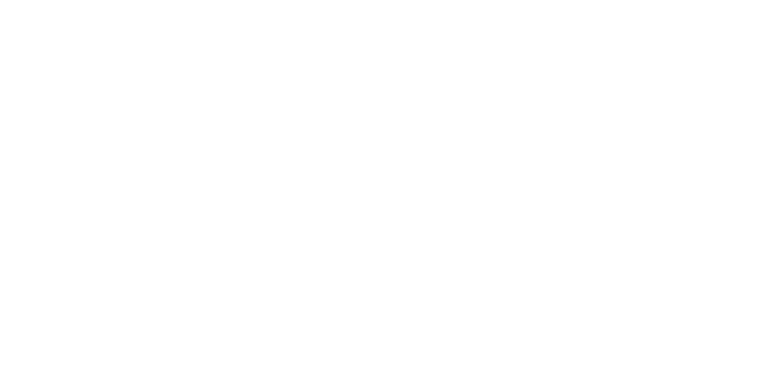

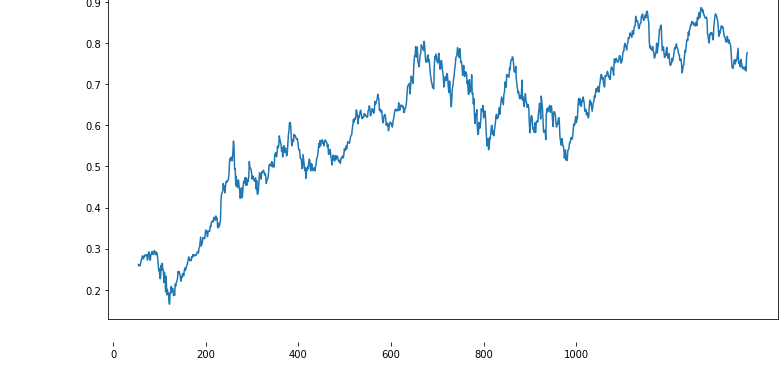

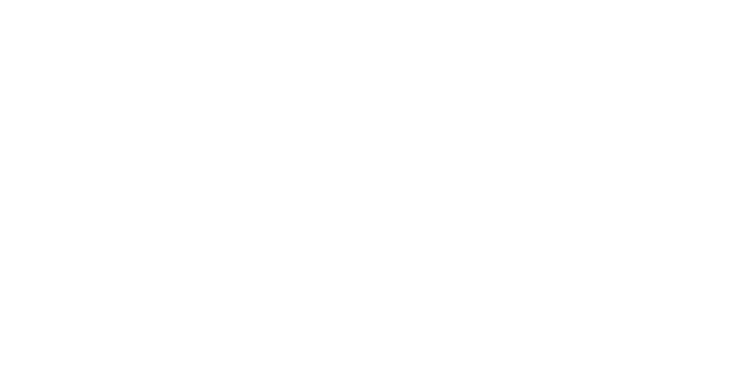

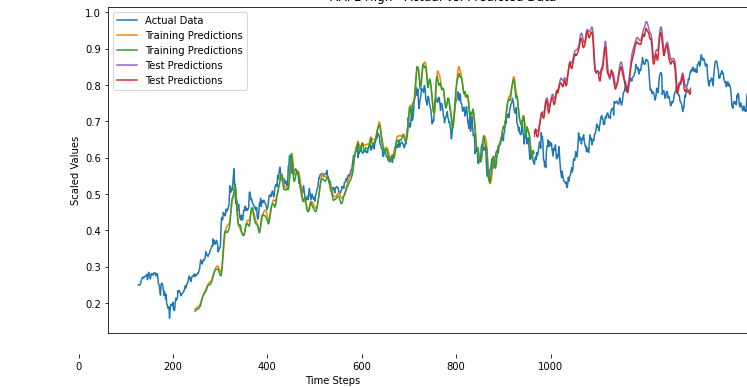

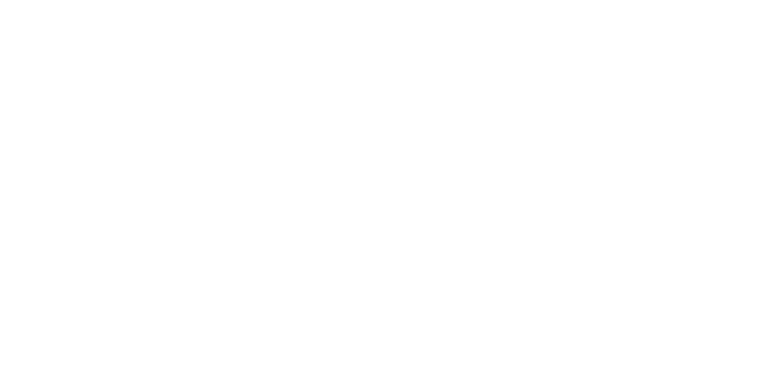

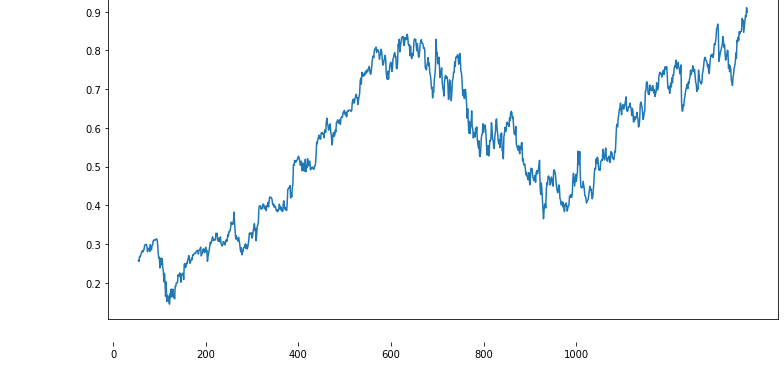

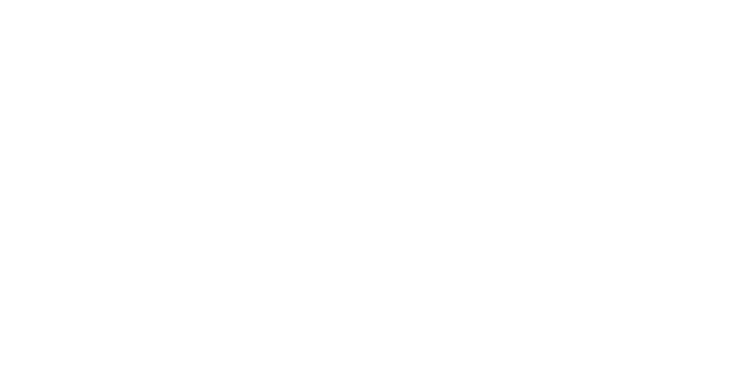

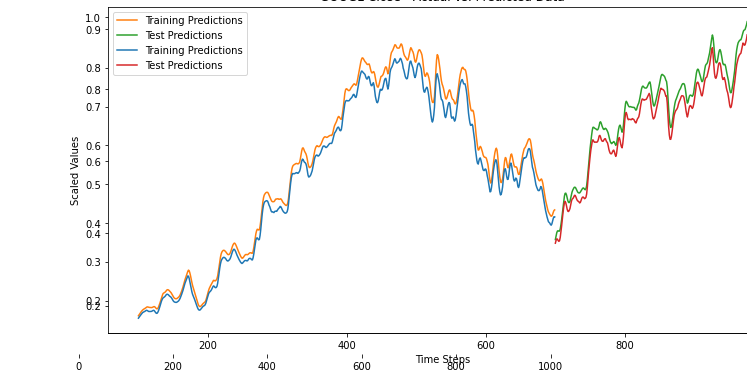

In [ ]:
for stock_name in stock_tickers:
    plot_stocks(stock_name)

In [ ]:
import numpy as np
import pandas as pd
import concurrent.futures
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Create a list of models and scalers
models_list = []
scalers_list = []
for col_name in columns_to_process:
    models_list.append(stocks_model_dict[stock_name][col_name][0])
    scalers_list.append(stocks_model_dict[stock_name][col_name][1])

In [ ]:
scalers_list

[MinMaxScaler(), MinMaxScaler()]

In [ ]:
# Define input parameters
n_steps = 100
forecast_days = 30

# Prepare input data for prediction
x_inputs_list = []
for stock, stock_data in x_input_dict.items():
    for col_name, test_data in stock_data.items():
        l = len(test_data)
        x_input = test_data[l - n_steps:].reshape(1, -1)
        temp_input = list(x_input)
        temp_input = temp_input[0].tolist()
        inputt = [temp_input, x_input]
        x_inputs_list.append((stock, col_name, inputt))


In [ ]:
# Function to predict next days using a trained model
def predict_next_days_parallel(args):
    stock_name, col_name, inputt, n_steps, forecast_days = args
    model = stocks_model_dict[stock_name][col_name][0]
    scaler = stocks_model_dict[stock_name][col_name][1]

    lst_output = []
    i = 0
    temp_input = inputt[0]
    x_input = inputt[1]

    while i < forecast_days:
        if len(temp_input) >= n_steps:
            x_input = np.array(temp_input[-n_steps:])  # Use the last n_steps elements
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            yhat = scaler.inverse_transform(yhat)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i = i + 1


        else:
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            yhat = scaler.inverse_transform(yhat)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i = i + 1

    return stock_name, col_name, lst_output

In [ ]:
# Parallel prediction of next days
# Prepare arguments for prediction
prediction_args = [(stock_name, col_name, inputt, n_steps, forecast_days) for stock_name, col_name, inputt in x_inputs_list]

with concurrent.futures.ThreadPoolExecutor(max_workers=len(models_list)) as executor:
    forecasted_data = list(executor.map(predict_next_days_parallel, prediction_args))

In [ ]:
# Iterate through the columns and store the forecasted data in the dictionary
forecasted_data_dict = {}
for stock_name, col_name, forecasted_data_list in forecasted_data:
    forecasted_data_dict[stock_name] = forecasted_data_dict.get(stock_name, {})
    forecasted_data_dict[stock_name][col_name] = forecasted_data_list


In [ ]:
forecasted_data_dict

{'AAPL': {'Close': [[0.8045719265937805],
   [0.812904953956604],
   [0.8157439231872559],
   [0.8149458169937134],
   [0.8122024536132812],
   [0.8085322380065918],
   [0.804427981376648],
   [0.8001072406768799],
   [0.7956788539886475],
   [0.7912228107452393],
   [0.7868111729621887],
   [0.7825070023536682],
   [0.7783598899841309],
   [0.7744032740592957],
   [0.7706555724143982],
   [0.767120361328125],
   [0.7637909054756165],
   [0.7606526613235474],
   [0.7576864361763],
   [0.7548706531524658],
   [0.7521824240684509],
   [0.7496002912521362],
   [0.747104823589325],
   [0.7446790933609009],
   [0.7423090934753418],
   [0.7399839162826538],
   [0.7376960515975952],
   [0.7354400753974915],
   [0.7332136631011963],
   [0.7310160398483276]],
  'High': [[0.8041735291481018],
   [0.811347484588623],
   [0.8072774410247803],
   [0.7979949712753296],
   [0.7872092127799988],
   [0.7764763832092285],
   [0.7663469314575195],
   [0.7570326924324036],
   [0.7486180663108826],
   [0.7

In [ ]:
total_days = len(dataframe_dict[stock_name][col_name])


In [ ]:
# Assuming 'AAPL' stock, 'Close' column
scaler = stocks_model_dict['AAPL']['Close'][1]
forecasted_data = forecasted_data_dict['AAPL']['Close']

# Reshape if necessary
# forecasted_data = forecasted_data.reshape(-1, 1)

# Inverse transform
k = scaler.inverse_transform(forecasted_data)
k

array([[0.7455506 ],
       [0.75156636],
       [0.75361587],
       [0.7530397 ],
       [0.75105922],
       [0.74840962],
       [0.74544668],
       [0.74232746],
       [0.73913053],
       [0.73591363],
       [0.73272879],
       [0.72962153],
       [0.72662766],
       [0.72377131],
       [0.72106577],
       [0.71851364],
       [0.71611005],
       [0.71384449],
       [0.71170312],
       [0.70967036],
       [0.70772967],
       [0.70586559],
       [0.70406406],
       [0.70231289],
       [0.70060194],
       [0.69892335],
       [0.6972717 ],
       [0.69564307],
       [0.69403578],
       [0.69244928]])

In [ ]:
import concurrent.futures
import matplotlib.pyplot as plt

# Function for plotting total original vs. predicted data
def plot_total_data(args):
    stock_name, col_name, forecast_days, original_data, forecasted_data = args
    total_days = len(dataframe_dict[stock_name][col_name])
     # Transform the predicted data back to original form
    predicted_data = stocks_scalers[stock_name][col_name].inverse_transform(forecasted_data)




    print("Original Data Values:", original_data[:5])
    print("Scaled Values:", forecasted_data[:5])
    print("Inverse Transformed Values:", predicted_data[:5])



    # Create an array for the x-axis (time steps)
    day_total = np.arange(1, total_days + 1)
    day_pred = np.arange(total_days + 1, total_days + forecast_days + 1)

    # Create a new plot for each stock-column combination
    plt.figure(figsize=(4,2))

    # Plot the original data
    plt.plot(day_total, original_data, label="Original Data")
    plt.plot(day_pred, predicted_data, label="Predicted Data")
    #print("Actual Data Values:", processed_data[:5])
    #print("Scaled Values:", stocks_scalers[stock_name][col_name].inverse_transform(processed_data)[:5])
    #print("Inverse Transformed Values:", stocks_scalers[stock_name][col_name].inverse_transform(forecasted_data)[:10])


    # Set titles and labels
    plt.title(f"{stock_name} - {col_name} - Original vs. Predicted Data")
    plt.xlabel("Time Steps")
    plt.ylabel("Original Values")
    plt.legend()

    # Show the plot outside the executor context
    plt.show()

# Iterate through the stocks and columns
for stock_name, stock_data in stocks_dict.items():
    for col_name, processed_data in stock_data.items():
        # Retrieve the corresponding scaler object

        # Get the predicted data
        original_data = dataframe_dict[stock_name][col_name]
        forecasted_data = forecasted_data_dict[stock_name][col_name]

        # Pass the scaled processed_data instead of unscaled original_data
        args = stock_name, col_name, forecast_days, original_data, forecasted_data

        # Run the plot_total_data function in parallel using a thread pool executor
        with concurrent.futures.ThreadPoolExecutor() as executor:
            executor.submit(plot_total_data, args)

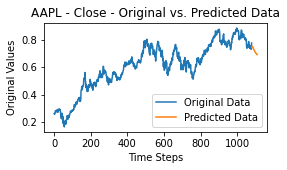

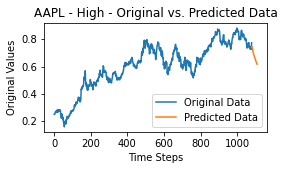

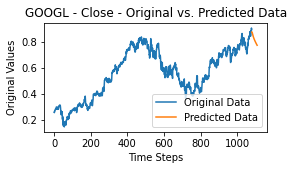

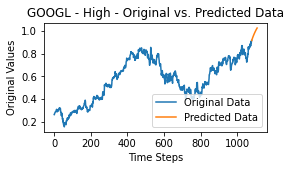

In [ ]:
import concurrent.futures
import matplotlib.pyplot as plt

# Function for plotting total original vs. predicted data
def plot_total_data(args):
    stock_name, col_name, forecast_days, processed_data, scaler, forecasted_data = args
    total_days = len(dataframe_dict[stock_name][col_name])

    # Skip plotting for 'Sentiment' column
    if col_name == 'Sentiment':
        return

    # Transform the predicted data back to original form
    predicted_data = scaler.inverse_transform(forecasted_data)

    # Create an array for the x-axis (time steps)
    day_total = np.arange(1, total_days + 1)
    day_pred = np.arange(total_days + 1, total_days + forecast_days + 1)

    # Create a new plot for each stock-column combination
    plt.figure(figsize=(4,2))

    # Plot the original data
    plt.plot(day_total, scaler.inverse_transform(processed_data), label="Original Data")

    # Plot the predicted data
    plt.plot(day_pred, scaler.inverse_transform(forecasted_data), label="Predicted Data")

    # Set titles and labels
    plt.title(f"{stock_name} - {col_name} - Original vs. Predicted Data")
    plt.xlabel("Time Steps")
    plt.ylabel("Original Values")
    plt.legend()

    # Show the plot outside the executor context
    plt.show()

# Iterate through the stocks and columns
for stock_name, stock_data in stocks_dict.items():
    for col_name, processed_data in stock_data.items():
        # Skip plotting for 'Sentiment' column
        if col_name == 'Sentiment':
            continue

        # Retrieve the corresponding scaler object
        scaler = stocks_model_dict[stock_name][col_name][1]

        # Get the predicted data
        original_data = dataframe_dict[stock_name][col_name]
        forecasted_data = forecasted_data_dict[stock_name][col_name]

        # Pass the scaled processed_data instead of unscaled original_data
        args = stock_name, col_name, forecast_days, processed_data, scaler, forecasted_data

        # Run the plot_total_data function in parallel using a thread pool executor
        with concurrent.futures.ThreadPoolExecutor() as executor:
            executor.submit(plot_total_data, args)


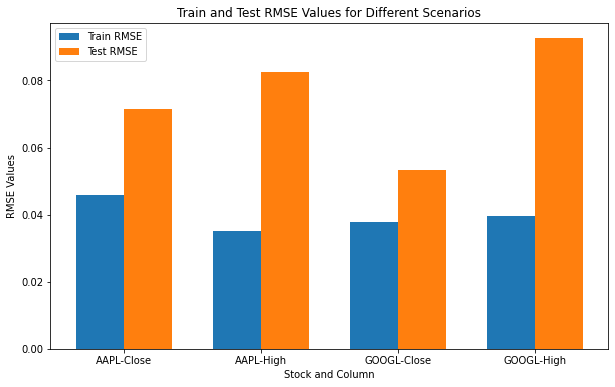

In [ ]:
import matplotlib.pyplot as plt

# RMSE values
#train_rmse_values = [0.07469319414434153, 0.07218243003094675, 0.09558321419085616, 0.09554875919496078]
#test_rmse_values = [0.02508495484383773, 0.027967204763158202, 0.034069569289616554, 0.03671280079008194]

# Stock and Column labels
labels = ['AAPL-Close', 'AAPL-High', 'GOOGL-Close', 'GOOGL-High']

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(len(labels))

bar1 = ax.bar(index, train_rmse_values, bar_width, label='Train RMSE')
bar2 = ax.bar([i + bar_width for i in index], test_rmse_values, bar_width, label='Test RMSE')

# Adding labels
ax.set_xlabel('Stock and Column')
ax.set_ylabel('RMSE Values')
ax.set_title('Train and Test RMSE Values for Different Scenarios')
ax.set_xticks([i + bar_width/2 for i in index])
ax.set_xticklabels(labels)
ax.legend()

# Display the plot
plt.show()
